## CUSTOMER SEGMENTATION PROJECT

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Understanding what are the features in our data

In [3]:
df=pd.read_csv(r'G:\weather\online_retail_II.csv')
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


Cleaning data & removing missing values 

In [4]:
# Drop rows with missing CustomerID 
df = df[df['Customer ID'].notnull()]

# Remove canceled orders (Invoice that starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove rows with non-positive quantity or unit price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Add a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Reset index
df = df.reset_index(drop=True)


In [5]:
print(df.info())
print(df.describe())
print(df['Country'].nunique())  # How many countries
print(df['Customer ID'].nunique())  # How many customers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805549 entries, 0 to 805548
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      805549 non-null  object 
 1   StockCode    805549 non-null  object 
 2   Description  805549 non-null  object 
 3   Quantity     805549 non-null  int64  
 4   InvoiceDate  805549 non-null  object 
 5   Price        805549 non-null  float64
 6   Customer ID  805549 non-null  float64
 7   Country      805549 non-null  object 
 8   TotalPrice   805549 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 55.3+ MB
None
            Quantity          Price    Customer ID     TotalPrice
count  805549.000000  805549.000000  805549.000000  805549.000000
mean       13.290522       3.206561   15331.954970      22.026505
std       143.634088      29.199173    1696.737039     224.041928
min         1.000000       0.001000   12346.000000       0.001000
25%         2.00000

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# THis step is crucial because if we are purchasing a product today 
# and it is last day of  purchasing then the  Recency = analysis_date - last_purchase_date. so we can calculate how recent someone’s last purchase was.
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Analysis Date:", analysis_date)


Analysis Date: 2011-12-10 12:50:00


In [7]:
# RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,   # ---Recency
    'Invoice': 'nunique',                                     # ---Frequency
    'TotalPrice': 'sum'                                         # ---Monetary
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [8]:
# RFM Sc0ring 
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# RFM Segment 
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# RFM Score 
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,12346.0,326,12,77556.46,2,5,5,255,12
1,12347.0,2,8,5633.32,5,4,5,545,14
2,12348.0,75,5,2019.40,3,4,4,344,11
3,12349.0,19,4,4428.69,5,3,5,535,13
4,12350.0,310,1,334.40,2,1,2,212,5


In [9]:
# Top scoring customers (e.g. VIPs)
top_customers = rfm[rfm['RFM_Score'] >= 13]
print("Top customers:", top_customers.shape[0])

# Simple segmenting based on score
def segment_customer(df):
    if df['RFM_Score'] >= 13:
        return 'Champions'
    elif df['RFM_Score'] >= 9:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm['Segment'].value_counts()


Top customers: 1297


Segment
Potential Loyalist    1914
Loyal Customers       1863
Champions             1297
At Risk                804
Name: count, dtype: int64

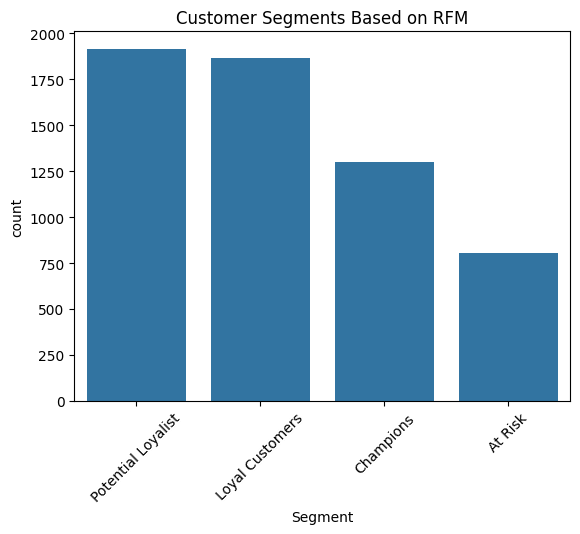

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments Based on RFM")
plt.xticks(rotation=45)
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler

rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)


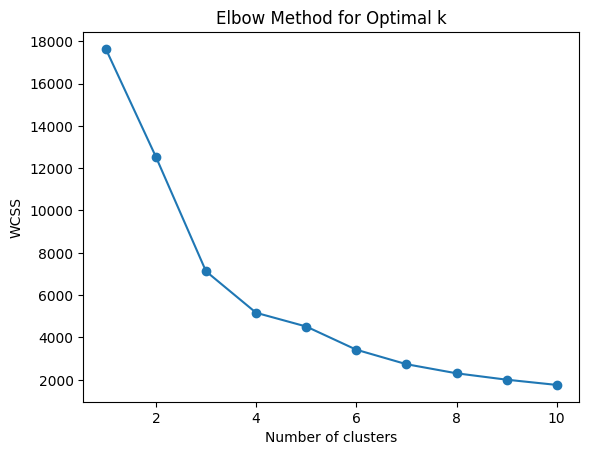

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


So we can take K = 3 or 4 .Let's choose 4 this time


In [13]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [14]:
# Average RFM values per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'CustomerCount'}).round(1)

cluster_summary


,Recency,Frequency,Monetary,RFM_Score,CustomerCount
Cluster,,,,,
0,463.0,2.2,765.2,5.6,1998
1,67.0,7.3,3009.4,10.7,3841
2,25.9,103.7,83086.1,14.6,35
3,3.5,212.5,436835.8,15.0,4


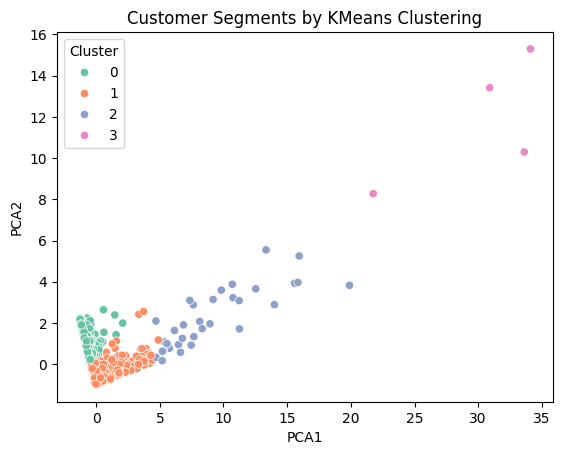

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = components[:, 0]
rfm['PCA2'] = components[:, 1]

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set2')
plt.title('Customer Segments by KMeans Clustering')
plt.show()


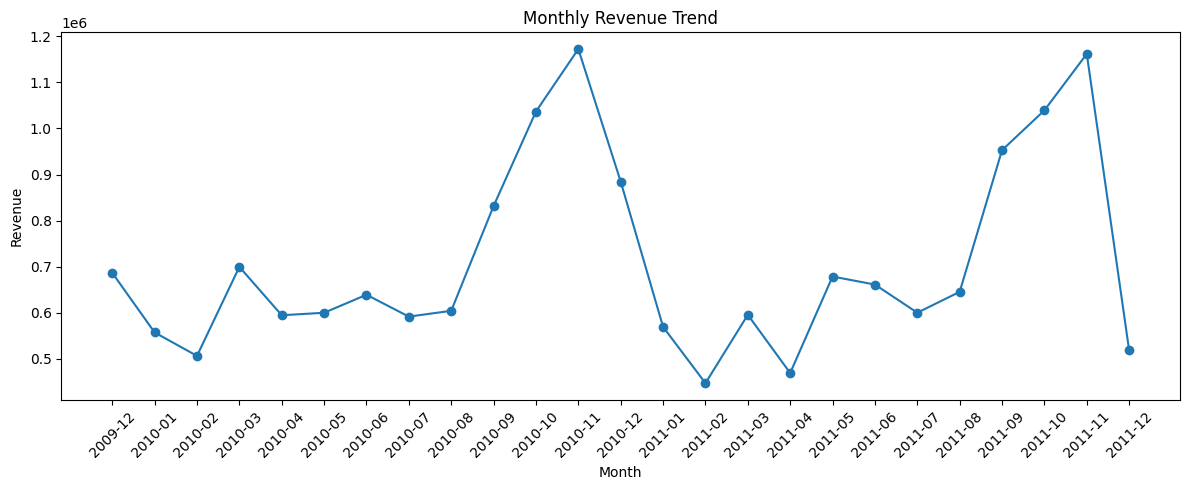

In [16]:
# Add a month column
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Monthly revenue
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_revenue['InvoiceMonth'].astype(str), monthly_revenue['TotalPrice'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


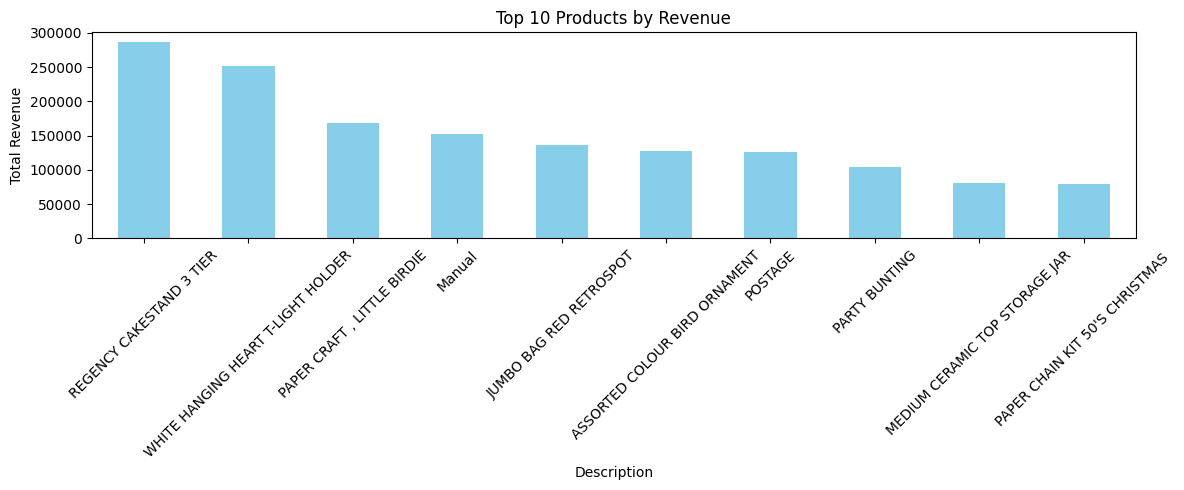

In [17]:
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind='bar', figsize=(12,5), color='skyblue')
plt.title('Top 10 Products by Revenue')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


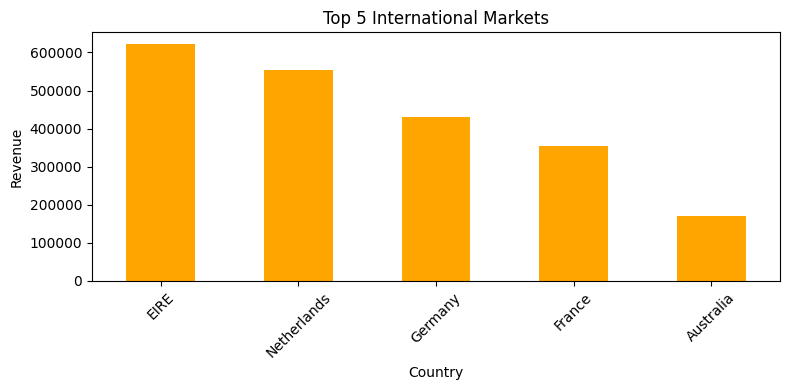

In [18]:
top_countries = (
    df[df['Country'] != 'United Kingdom']
    .groupby('Country')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_countries.plot(kind='bar', figsize=(8,4), color='orange')
plt.title('Top 5 International Markets')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
order_values = df.groupby('Invoice')['TotalPrice'].sum()
aov = order_values.mean()

print(f"Average Order Value: EUR{aov:.2f}")


Average Order Value: EUR479.95


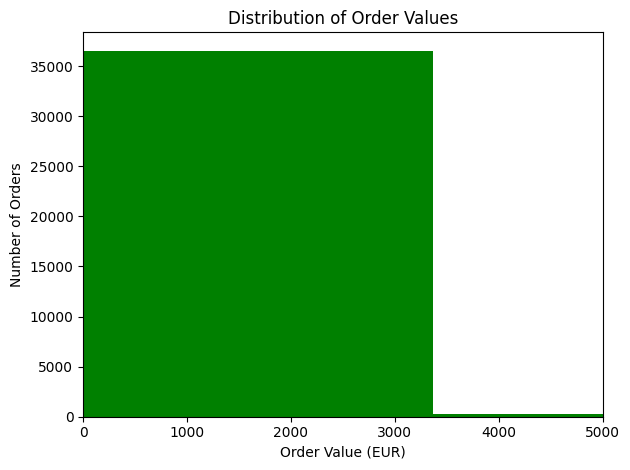

In [25]:
plt.hist(order_values, bins=50, color='green')
plt.title('Distribution of Order Values')
plt.xlabel('Order Value (EUR)')
plt.ylabel('Number of Orders')
plt.xlim(0, 5000)  
plt.tight_layout()
plt.show()


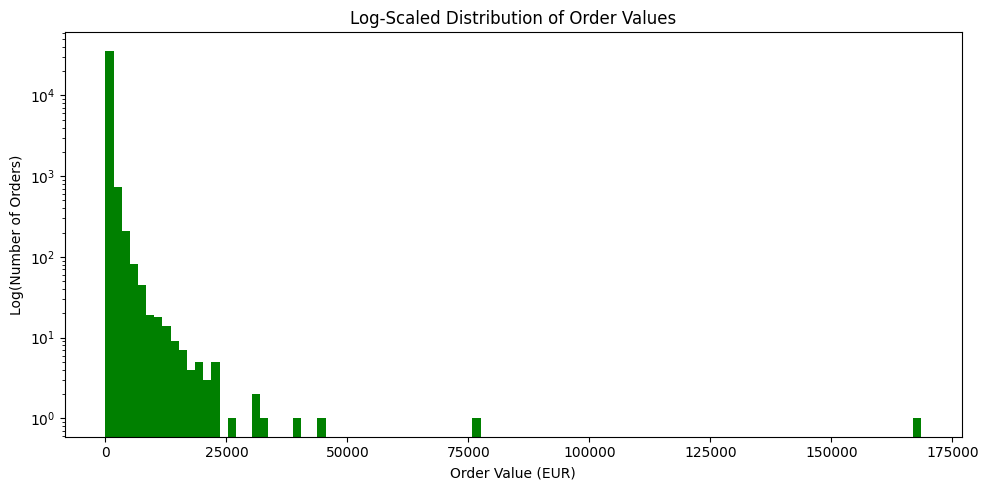

In [26]:
#  drawing again for better visualization the above graph
plt.figure(figsize=(10, 5))
plt.hist(order_values, bins=100, color='green', log=True)
plt.title('Log-Scaled Distribution of Order Values')
plt.xlabel('Order Value (EUR)')
plt.ylabel('Log(Number of Orders)')
plt.tight_layout()
plt.show()


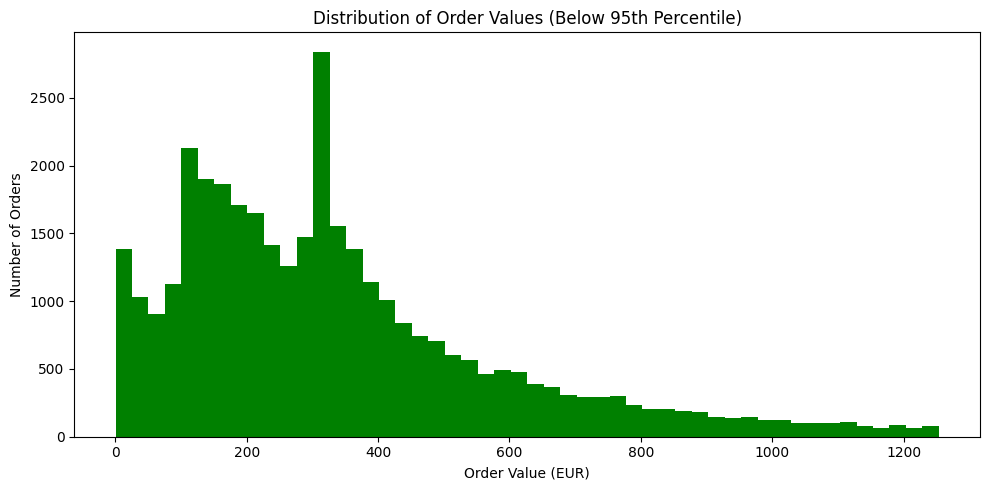

In [28]:
# Calculate 95th percentile cutoff [removing outliers]
cutoff = order_values.quantile(0.95)

plt.figure(figsize=(10, 5))
plt.hist(order_values[order_values < cutoff], bins=50, color='green')
plt.title('Distribution of Order Values (Below 95th Percentile)')
plt.xlabel('Order Value (EUR)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


In [29]:

print(f" Total Revenue: EUR-{df['TotalPrice'].sum():,.2f}")
print(f" Unique Customers: {df['Customer ID'].nunique()}")
print(f"Total Orders: {df['Invoice'].nunique()}")
print(f" Average Order Value: EUR-{df.groupby('Invoice')['TotalPrice'].sum().mean():.2f}")


 Total Revenue: EUR-17,743,429.18
 Unique Customers: 5878
Total Orders: 36969
 Average Order Value: EUR-479.95
